## Gesture Recognition

#### In this group project, you are going to build a 3D Conv & Cnn+Rnn model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import cv2
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from keras import backend as K
import tensorflow as tf
import random as rn
import abc
from sys import getsizeof

Using TensorFlow backend.


In [2]:
np.random.seed(30)

rn.seed(30)

tf.set_random_seed(30)

In [3]:
os.listdir()

['model_init_2020-06-2816_46_12.927062',
 'train',
 'model_init_2020-06-2818_51_49.959599',
 'model_init_2020-06-2815_43_10.084580',
 'Neural_Nets_Project_Starter.ipynb',
 'val',
 'model_init_2020-06-2817_57_58.424462',
 'model_init_2020-06-2907_24_41.255214',
 'model_init_2020-06-2817_21_29.743583',
 'model_init_2020-06-2908_42_49.606984',
 'model_init_2020-06-2908_08_44.074049',
 'Neural_Nets_Project_Starter_Code_final.ipynb',
 'val.csv',
 '.ipynb_checkpoints',
 'model_init_2020-06-2907_53_02.010162',
 'model_init_2020-06-2818_14_17.454572',
 'train.csv',
 'model_init_2020-06-2906_50_20.825697',
 'Neural_Nets_Project_Starter_Code.ipynb',
 'model_init_2020-06-2817_54_59.992343',
 'model_init_2020-06-2906_14_33.312744',
 'model_init_2020-06-2907_50_23.382046']

#### In this block, you read the folder names for training and validation. You also set the batch_size here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
train_doc = np.random.permutation(open(r'train.csv').readlines())
val_doc = np.random.permutation(open(r'val.csv').readlines())
batch_size = 10 #experiment with the batch size

In [5]:
project_folder='train'

In [6]:
rows = 120   # X 
cols = 120   # Y 
channel = 3  # number of channels in images 3 for color(RGB)
frames=15

In [7]:
#data resizing - Resizing all the images, so we can have all the images in a specific size
def crop_resize_img(img):
    if img.shape[0] != img.shape[1]:
        img=img[0:120,10:150]
    resized_image = imresize(img, (rows,cols))
    return resized_image

In [8]:
#using percentile to deal with outliers in the data.
def normalize_image(img):
    #using percentile for normalization for images, as min-max is giving better results.
    # normalized_image= img - np.percentile(img,15)/ np.percentile(img,85) - np.percentile(img,15) 
    normalized_image= (img - np.min(img))/(np.max(img)- np.min(img))
    return normalized_image

In [9]:
# Preprocessing the images before feed data to the model in batches.


def fetch_aug_batchdata(source_path, folder_list, batch_num, batch_size, t,validation):
    
    # intialize variables to store data read from train data
    batch_data = np.zeros((batch_size,frames,rows,cols,channel)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
    batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
    #print(batch_data)
    #print(batch_labels)
    # intialize variables for augumented batch data with affine transformation
    batch_data_aug,batch_label_aug = batch_data,batch_labels
    #print(batch_data_aug)
    #print(batch_label_aug)
    # intialize variables for augmented batch data with horizontal flip
    batch_data_flip,batch_label_flip = batch_data,batch_labels
    
    #create a list of image numbers you want to use for a particular video using full frames
    img_idx = [x for x in range(0, 30,2)] 
    
    for folder in range(batch_size): # iterate over the batch_size
        # read all the images in the folder
        imgs = sorted(os.listdir(source_path+'/'+ t[folder + (batch_num*batch_size)].split(';')[0])) 
        # create a random affine to be used in image transformation for buidling agumented data set
        dx, dy = np.random.randint(-1.7, 1.8, 2)
        M = np.float32([[1, 0, dx], [0, 1, dy]])
        
        #  Iterate over the frames for each folder to read them in
        for idx, item in enumerate(img_idx):             
            image = cv2.imread(source_path+'/'+ t[folder + (batch_num*batch_size)].strip().split(';')[0]+'/'+imgs[item], cv2.IMREAD_COLOR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)           
            # Cropping non symmetric frames
            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes 
            resized_image=crop_resize_img(image)
            
            #Normal data
            batch_data[folder,idx,:,:,0] = normalize_image(resized_image[:, : , 0])#normalise and feed in the image
            batch_data[folder,idx,:,:,1] = normalize_image(resized_image[:, : , 1])#normalise and feed in the image
            batch_data[folder,idx,:,:,2] = normalize_image(resized_image[:, : , 2])#normalise and feed in the image
            
            x =resized_image.shape[0]
            y =resized_image.shape[1]
            #Data with affine transformation
            batch_data_aug[folder,idx] = (cv2.warpAffine(resized_image, M, (x,y)))
            
            # Data with horizontal flip
            batch_data_flip[folder,idx]= np.flip(resized_image,1)

        batch_labels[folder, int(t[folder + (batch_num*batch_size)].strip().split(';')[2])] = 1
        batch_label_aug[folder, int(t[folder + (batch_num*batch_size)].strip().split(';')[2])] = 1
        
        if int(t[folder + (batch_num * batch_size)].strip().split(';')[2])==0:
            batch_label_flip[folder, 1] = 1
        elif int(t[folder + (batch_num*batch_size)].strip().split(';')[2])==1:
            batch_label_flip[folder, 0] = 1                    
        else:
            batch_label_flip[folder, int(t[folder + (batch_num*batch_size)].strip().split(';')[2])] = 1
                  
    #adding the augumented data in the main data.
    
    batch_data_final = np.append(batch_data, batch_data_aug, axis = 0)
    batch_data_final = np.append(batch_data_final, batch_data_flip, axis = 0)

    batch_label_final = np.append(batch_labels, batch_label_aug, axis = 0) 
    batch_label_final = np.append(batch_label_final, batch_label_flip, axis = 0)
    
    if validation:
        batch_data_final=batch_data
        batch_label_final= batch_labels
        
    return batch_data_final,batch_label_final

### Generator

#### This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with img_idx, y,z and normalization such that you get high accuracy.

#### Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [10]:
class ModelBuilderMoreAugmentation(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open('train.csv').readlines())
        self.val_doc = np.random.permutation(open('val.csv').readlines())
        self.train_path = 'train'
        self.val_path = 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

In [11]:
curr_dt_time = datetime.datetime.now()
train_path = 'train'
val_path = 'val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30# choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


### Model

#### Here you make the model using different functionalities that Keras provides. Remember to use Conv3D and MaxPooling3D and not Conv2D and Maxpooling2D for a 3D convolution model. You would want to use TimeDistributed while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [12]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout,LSTM
from keras.layers.convolutional import Conv3D,Conv2D, MaxPooling3D,MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.applications import mobilenet
from keras.layers.recurrent import LSTM, GRU
from keras.optimizers import Adam
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 


#write your model here

In [13]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

### 1. CNN + RNN architecture

#### Now that you have written the model, the next step is to compile the model. When you print the summary of the model, you'll see the total number of parameters you have to train.

In [14]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL1(ModelBuilderMoreAugmentation):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [15]:
rnn_cnn_tl1=RNNCNN_TL1()
rnn_cnn_tl1.initialize_path(project_folder)
rnn_cnn_tl1.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl1.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=15)
rnn_cnn_tl1_model=rnn_cnn_tl1.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl1_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_2 (TimeDist (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 16, 1024)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               442752    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
__________

In [16]:
print("Total Params:", rnn_cnn_tl1_model.count_params())
history_model1=rnn_cnn_tl1.train_model(rnn_cnn_tl1_model,augment_data=True)

Total Params: 3692869
Epoch 1/15
133/133 [==============================] - 205s 2s/step - loss: 1.2128 - categorical_accuracy: 0.5110 - val_loss: 0.6459 - val_categorical_accuracy: 0.7700

Epoch 00001: saving model to model_init_2020-06-2917_29_15.848850/model-00001-1.21343-0.51056-0.64585-0.77000.h5
Epoch 2/15
133/133 [==============================] - 93s 702ms/step - loss: 0.6779 - categorical_accuracy: 0.7416 - val_loss: 0.4002 - val_categorical_accuracy: 0.8000

Epoch 00002: saving model to model_init_2020-06-2917_29_15.848850/model-00002-0.67903-0.74133-0.40015-0.80000.h5
Epoch 3/15
133/133 [==============================] - 95s 716ms/step - loss: 0.5084 - categorical_accuracy: 0.8028 - val_loss: 0.5128 - val_categorical_accuracy: 0.8400

Epoch 00003: saving model to model_init_2020-06-2917_29_15.848850/model-00003-0.50893-0.80317-0.51280-0.84000.h5
Epoch 4/15
133/133 [==============================] - 95s 713ms/step - loss: 0.4457 - categorical_accuracy: 0.8409 - val_loss: 0.41

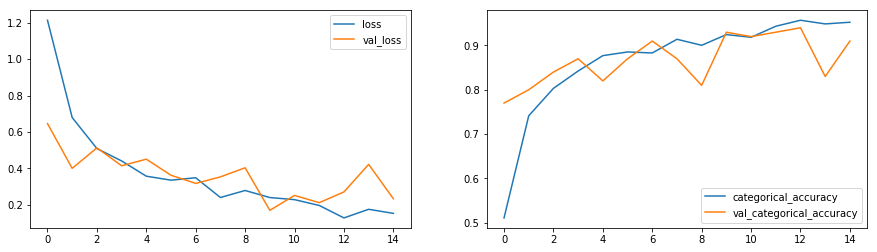

In [17]:
plot(history_model1)

### 2. Conv3D Model

In [19]:
class ModelConv3D(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [20]:
conv_3d=ModelConv3D()
conv_3d.initialize_path(project_folder)
conv_3d.initialize_image_properties(image_height=120,image_width=120)
conv_3d.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=25)
conv_3d_model=conv_3d.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_1 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_2 (Activation)    (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 8, 60, 60, 32)     128       
__________

In [22]:
print("Total Params:", conv_3d_model.count_params())
history_model2=conv_3d.train_model(conv_3d_model,augment_data=True)

Total Params: 1762613
Epoch 1/25
23/23 [==============================] - 96s 4s/step - loss: 2.3408 - categorical_accuracy: 0.3021 - val_loss: 1.3482 - val_categorical_accuracy: 0.5600

Epoch 00001: saving model to model_init_2020-06-2917_59_29.166634/model-00001-2.30067-0.30090-1.34817-0.56000.h5
Epoch 2/25
23/23 [==============================] - 84s 4s/step - loss: 1.6674 - categorical_accuracy: 0.4546 - val_loss: 1.1152 - val_categorical_accuracy: 0.5700

Epoch 00002: saving model to model_init_2020-06-2917_59_29.166634/model-00002-1.62555-0.45928-1.11520-0.57000.h5
Epoch 3/25
23/23 [==============================] - 89s 4s/step - loss: 1.4270 - categorical_accuracy: 0.5174 - val_loss: 1.0315 - val_categorical_accuracy: 0.6600

Epoch 00003: saving model to model_init_2020-06-2917_59_29.166634/model-00003-1.40578-0.51810-1.03152-0.66000.h5
Epoch 4/25
23/23 [==============================] - 89s 4s/step - loss: 1.3692 - categorical_accuracy: 0.5366 - val_loss: 0.9356 - val_categoric

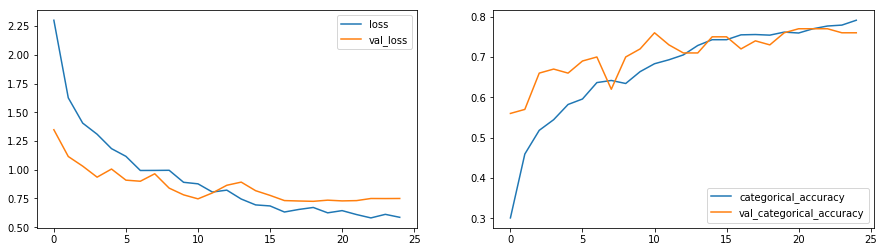

In [23]:
plot(history_model2)